<a href="https://colab.research.google.com/github/GasanaElysee12/Neural-ODE/blob/main/NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
%matplotlib inline

In [ ]:
def Euler(func,t,dt,y):
  return dt*func(t,y)

  

In [ ]:
def RK4(func,t,dt,y):
  one_half_dt=dt/2
  one_six_th=1/6
  k1=func(t,y)
  k2=func(t+one_half_dt,y+one_half_dt*k1)
  k3=func(t+one_half_dt,y+one_half_dt*k2)
  k4=func(t+dt,y+dt*k3)
  return (k1+k4+2*(k2+k3))*dt*one_six_th

In [ ]:
class NeuralODE(nn.Module):

  def __init__(self,func):
    super().__init__()

    self.func=func

  def forward(self,y0,t,solver):
    solution=torch.empty(len(t),*y0.shape,dtype=y0.dtype,device=y0.device)
    solution[0]=y0 
    #print('The size of the solution is: ',solution.shape,solution.dtype)
   # print('The size of the solution[0] is: ',y0.shape,y0.dtype)
    j=1
    for t0,t1 in zip(t[:-1],t[1:]):
     # print('For Each time , to and t1are :',t0.shape,t1.shape,t0.dtype,t1.dtype)
      dy=solver(self.func,t0,t1-t0,y0)
      #print('After solver dy is : ',dy.dtype,dy.shape)
      y1=y0+dy 
      solution[j]=y1
      j+=1
      y0=y1

     
    return solution

# Doing an experiment for checkin whether our neural ode perform perfectly

**Le's check whether for cos(t) will result in sin(t)**

In [ ]:
y0=torch.Tensor([[0]])
t=torch.linspace(0.,6*np.pi,1500)

class cos(nn.Module):
  

  def forward(self,t,y):
    return torch.cos(t)

In [ ]:
ode_test=NeuralODE(func=cos())

test_result=ode_test(y0=y0,t=t,solver=Euler)

test_result=test_result.transpose(0,1)

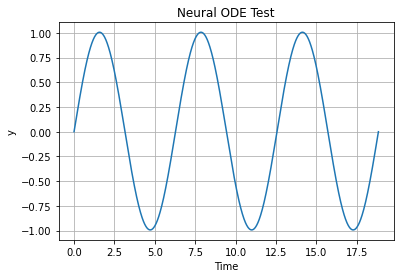

In [ ]:
#Visualize

fig=plt.figure()

ax=fig.add_subplot(1,1,1)
ax.set_title('Neural ODE Test')
ax.set_xlabel('Time')
ax.set_ylabel('y')

ax.plot(t.cpu().numpy(),test_result[0].detach().cpu().numpy())
plt.grid(True)
plt.show()

# Let create a spiral dataset

In [ ]:
datasize=2000
true_y0=torch.tensor([[2.,0.]])
t=torch.linspace(0.0,25.,datasize)
true_A=torch.tensor([[-0.1,2.0],[-2.0,-0.1]])

class Lambda(nn.Module):
  def __init__(self):
    super().__init__()
    pass
  

  def forward(self,t,y):
    
    return torch.mm(y**3,true_A)
with torch.no_grad():
  node=NeuralODE(func=Lambda())

  True_y=node(y0=true_y0,t=t,solver=Euler)

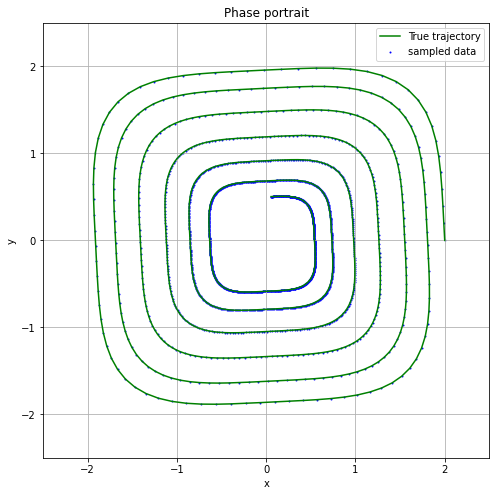

In [ ]:
def Viz(true_y,pred_y=None):
  fig=plt.figure(figsize=(8,8),facecolor='white')
  ax=fig.add_subplot(111)
  ax.set_title('Phase portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  # print('Before plotting:\n ',true_y.numpy()[:,0,1].shape,true_y.numpy()[:,0,0].shape)
  ax.plot(true_y.numpy()[:,0,0],true_y.numpy()[:,0,1],'green',label='True trajectory')
  ax.scatter(true_y.cpu().numpy()[:,0,0],true_y.cpu().numpy()[:,0,1],color='blue',label='sampled data',s=1)
  if pred_y is not None:

    ax.plot(pred_y.numpy()[:,0,0],pred_y.numpy()[:,0,1],'red',label='Learned trajectory')

  ax.set_xlim(-2.5,2.5)
  ax.set_ylim([-2.5,2.5])
  plt.legend()
  plt.grid(True)
  plt.show()
Viz(True_y)



In [ ]:
batch_time=10
batch_size=10

def get_batch():
  S=torch.from_numpy(np.random.choice(np.arange(datasize-batch_time,dtype=np.int64),batch_size,replace=False))
 # print(f'The shape of S is {S.shape}')

 # print(f'The shape of true_y0 is {true_y0.shape}')
  batch_y0=True_y[S]#(batch_size,1,emb)
  
  batch_t=t[:batch_time]  #T
 # print(f'The shape of batch_t is {batch_t.shape}')
  batch_y=torch.stack([True_y[S+i] for i in range(batch_time) ],dim=0)#(time,batch_size,1,emb)
  #print(f'The shape of batch_y is {batch_y.shape}')
  return batch_y0,batch_t,batch_y


# Define the dynamical function



In [ ]:
class ODEFunct(nn.Module):
  def __init__(self):
    super().__init__()

    #Let's create the network

    self.model=nn.Sequential(nn.Linear(2,50),
                             nn.Tanh(),
                             nn.Linear(50,2))
    for m in self.model.modules():
      if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight,mean=0,std=0.1)
        nn.init.constant_(m.bias,val=0)

    




  def forward(self,t,y):
    
    return self.model(y**3)

#Training

  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000|Total Loss: 2.270136


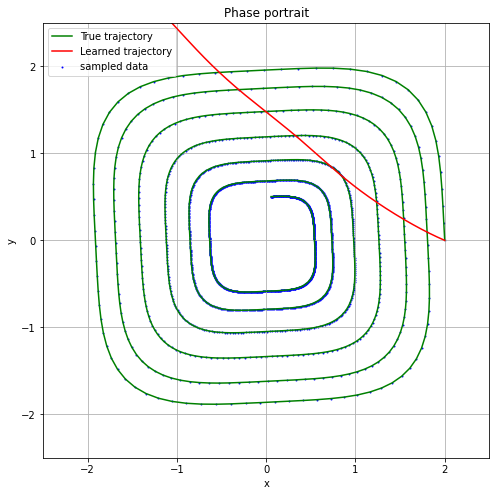

iter 0050|Total Loss: 1.190680


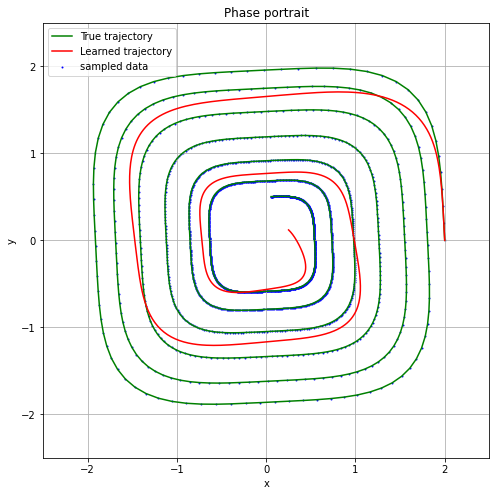

iter 0100|Total Loss: 1.233965


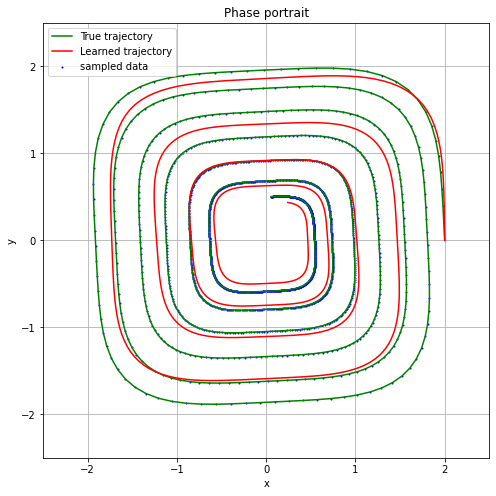

iter 0150|Total Loss: 1.376493


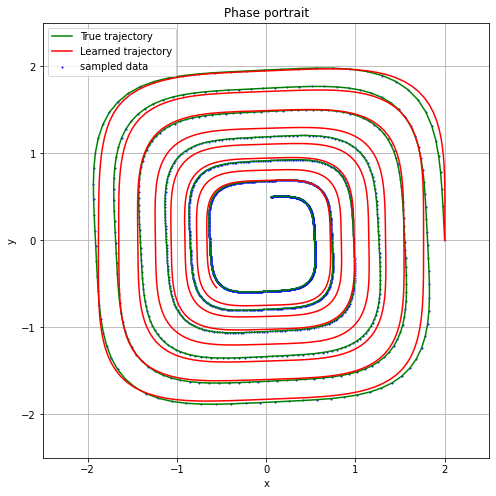

iter 0200|Total Loss: 1.303365


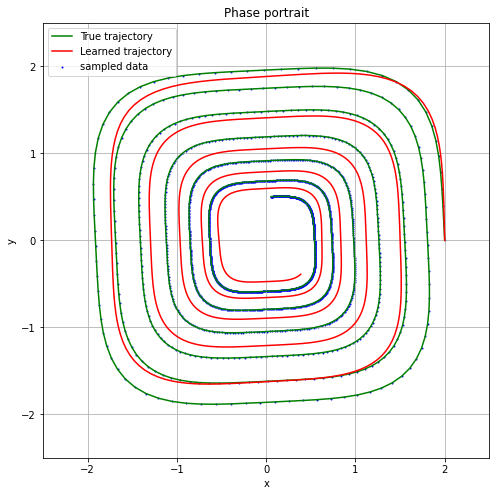

iter 0250|Total Loss: 1.265535


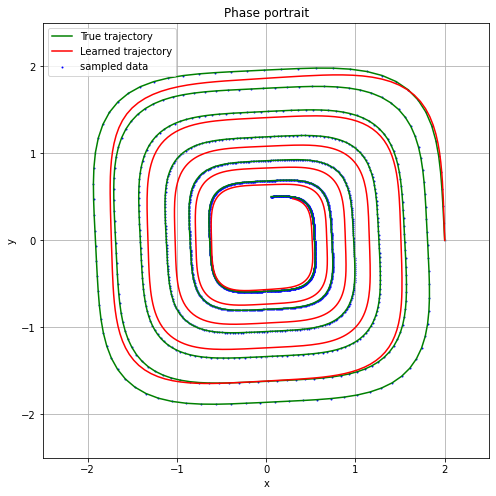

iter 0300|Total Loss: 1.301383


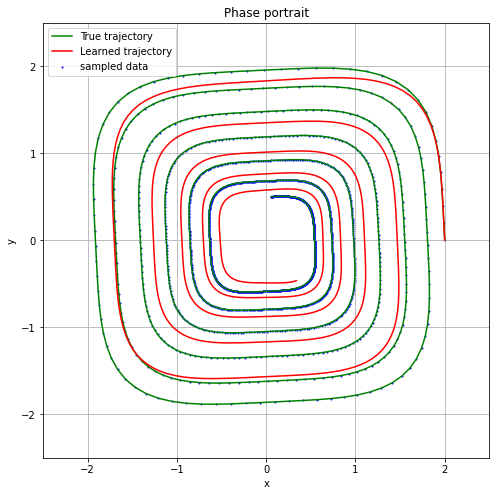

iter 0350|Total Loss: 1.311970


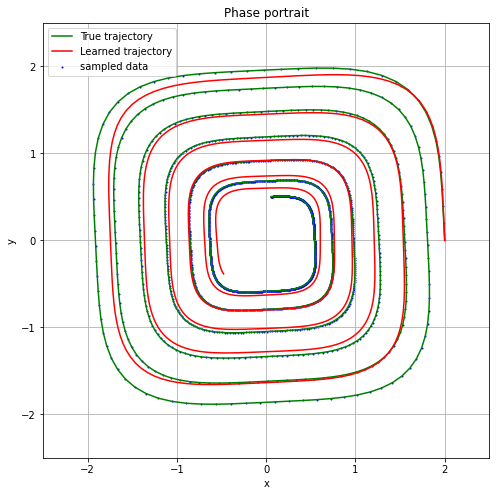

iter 0400|Total Loss: 1.282773


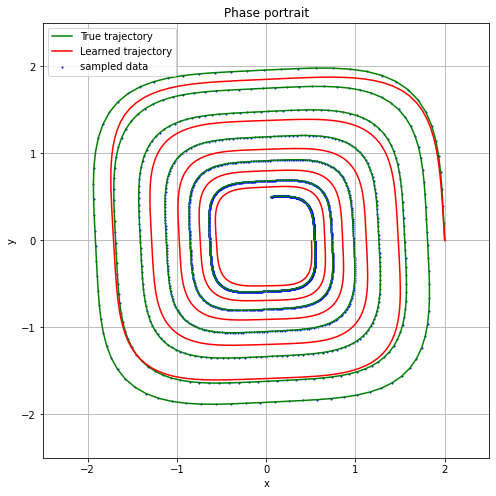

The process time: 12.218953847885132sec


In [ ]:
n_iters=400
node=NeuralODE(func=ODEFunct())
optimizer=optim.RMSprop(node.parameters(),lr=1e-3)


start_time=time.time()

for iter in tqdm(range(n_iters+1)):
  optimizer.zero_grad()
  batch_y0,batch_t,batch_y=get_batch()  #Here batch_y is the label
  # print(batch_y0.shape,batch_t.shape,batch_y.shape)
  pred_y=node(y0=batch_y0,t=batch_t,solver=RK4)#y0 will be the starting point and t will be the time step
  loss=torch.mean(torch.abs(pred_y-batch_y))
  loss.backward()
  optimizer.step()

  if iter%50==0:
    with torch.no_grad():
      pred_y=node(true_y0,t,solver=RK4)
      loss=torch.mean(torch.abs(pred_y-true_y0))
      print('iter {:04d}|Total Loss: {:.6f}'.format(iter,loss.item()))
      Viz(True_y,pred_y)

end_time=time.time()
print('The process time: {}sec'.format(end_time-start_time))



# 4th task
**Let now use Adaptive solver by using the pytorch package torchdiffeq**

*odeint(func,y0,t,rtol,atol,method)*
**rtol:optional float64 tensor specifying an upper bound relative error.
** atol: is the optional float64 tensor specifying an upper bound on absolute error

  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000|Total Loss: 6.469056


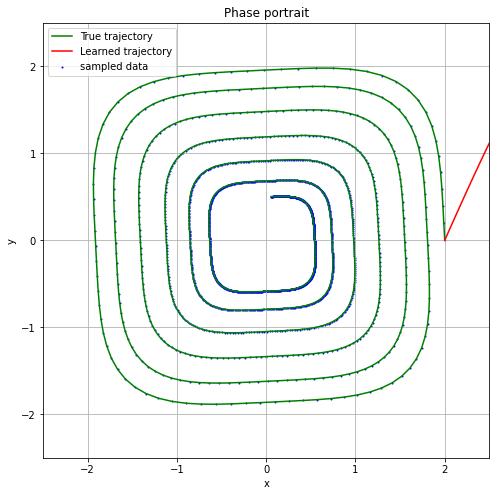

iter 0050|Total Loss: 1.272832


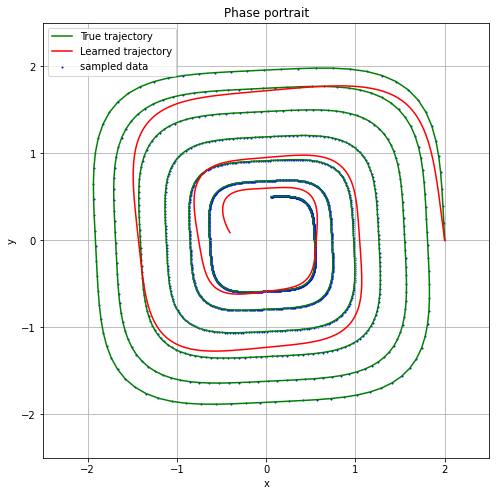

iter 0100|Total Loss: 1.302306


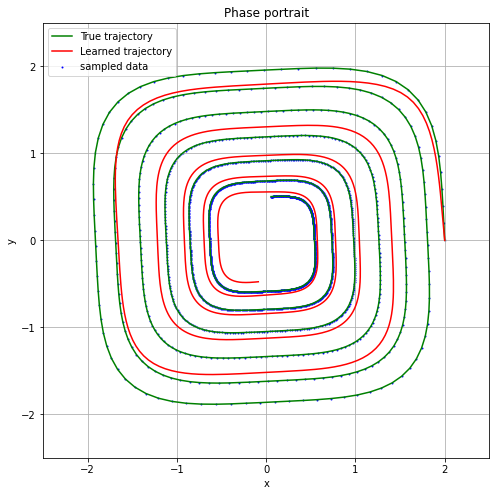

iter 0150|Total Loss: 1.291040


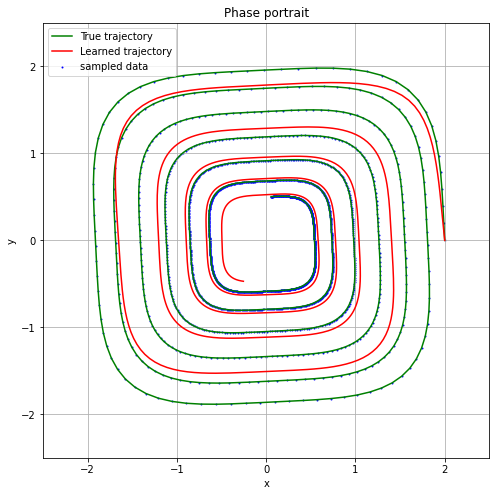

iter 0200|Total Loss: 1.276871


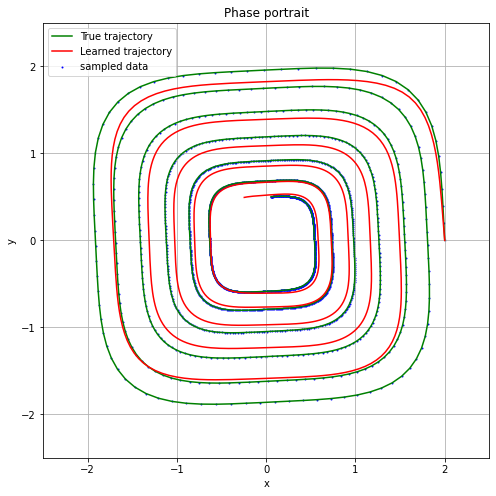

iter 0250|Total Loss: 1.288572


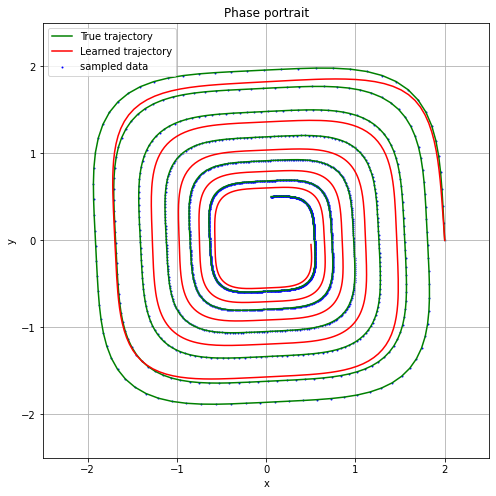

iter 0300|Total Loss: 1.265517


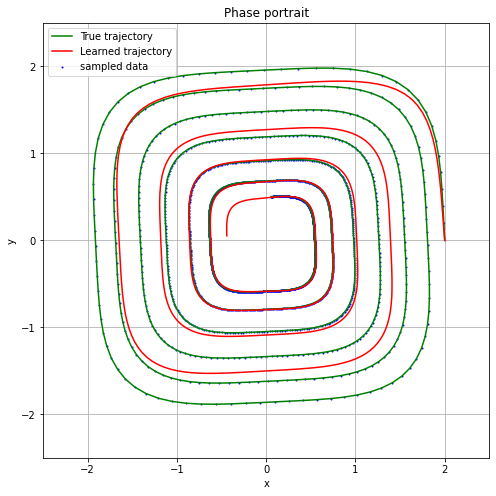

iter 0350|Total Loss: 1.282478


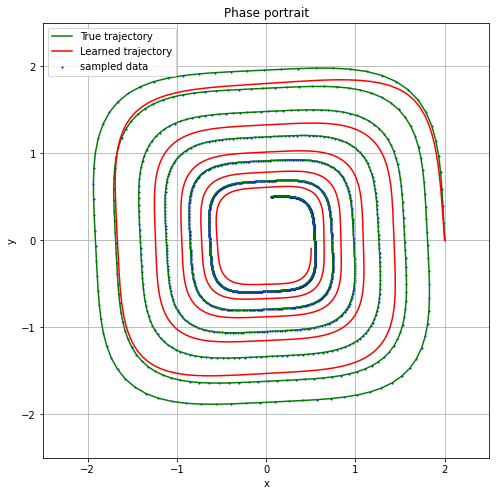

iter 0400|Total Loss: 1.269162


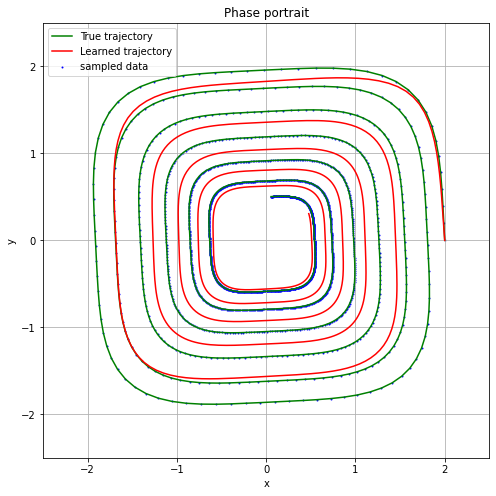

The process time: 22.716313362121582sec


In [ ]:
n_iters=400
func=ODEFunct()

optimizer=optim.RMSprop(func.parameters(),lr=1e-3)


start_time=time.time()

for iter in tqdm(range(n_iters+1)):
  optimizer.zero_grad()
  batch_y0,batch_t,batch_y=get_batch()  #Here batch_y is the label
  # print(batch_y0.shape,batch_t.shape,batch_y.shape)
  pred_y=odeint(func=func,y0=batch_y0,t=batch_t,rtol=1e-7,atol=1e-9,method='dopri5')#y0 will be the starting point and t will be the time step
  loss=torch.mean(torch.abs(pred_y-batch_y))
  loss.backward()
  optimizer.step()

  if iter%50==0:
    with torch.no_grad():
      pred_y=odeint(func,true_y0,t,rtol=1e-7,atol=1e-9,method='dopri5')
      loss=torch.mean(torch.abs(pred_y-true_y0))
      print('iter {:04d}|Total Loss: {:.6f}'.format(iter,loss.item()))
      Viz(True_y,pred_y)

end_time=time.time()
print('The process time: {}sec'.format(end_time-start_time))



  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000|Total Loss: 4.763792


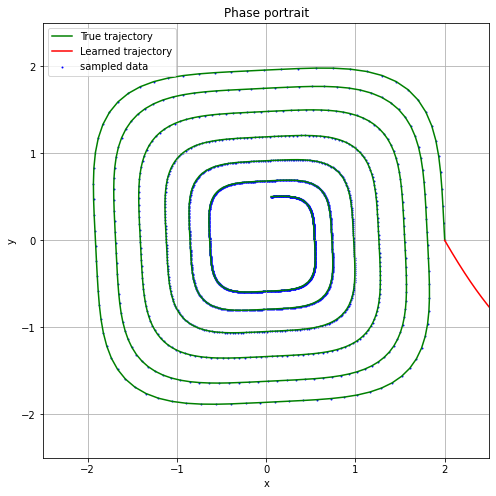

iter 0050|Total Loss: 1.273218


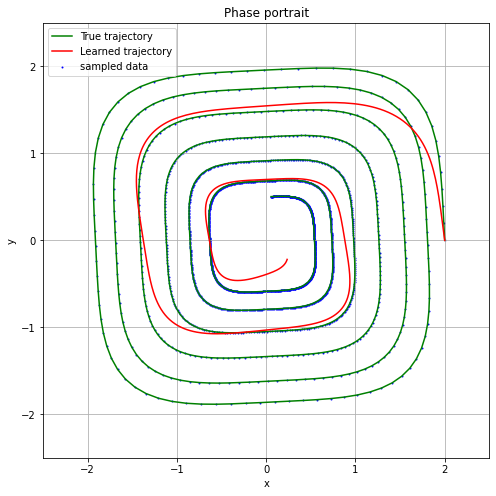

iter 0100|Total Loss: 1.271762


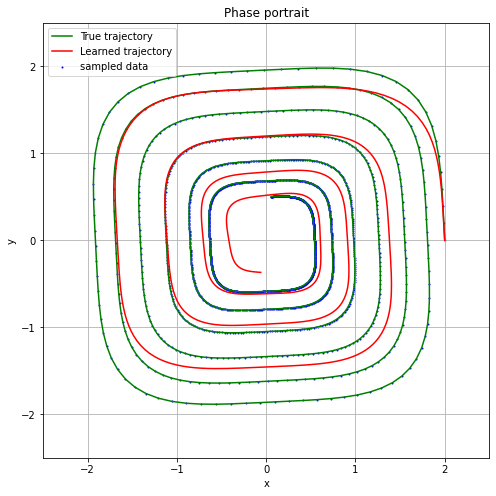

iter 0150|Total Loss: 1.289493


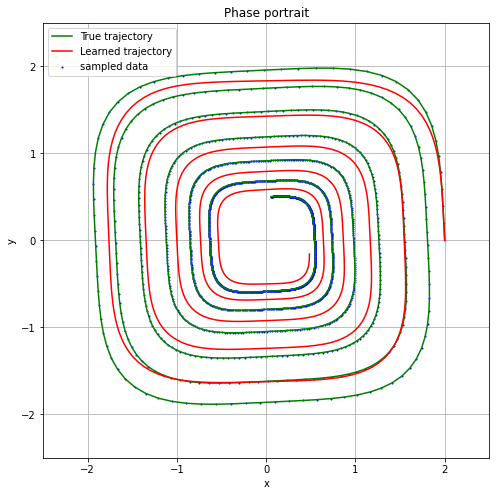

iter 0200|Total Loss: 1.255861


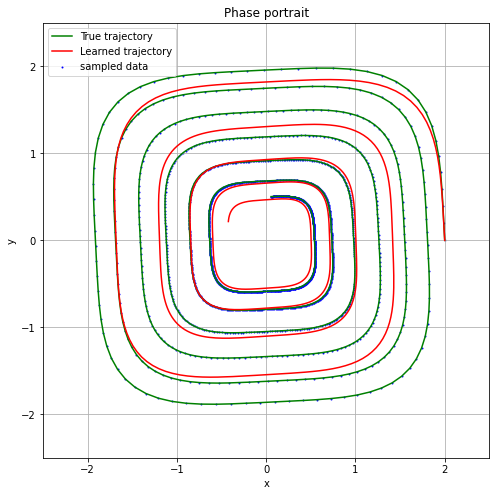

iter 0250|Total Loss: 1.228000


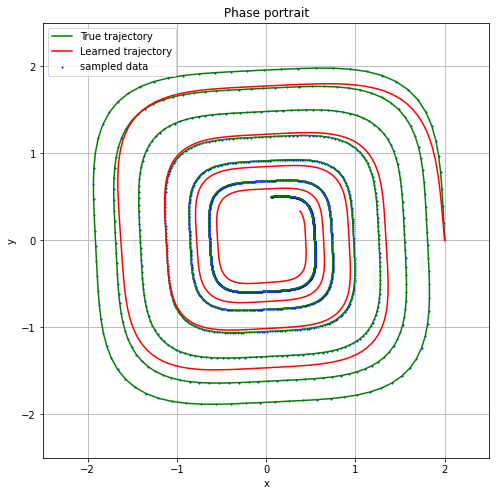

iter 0300|Total Loss: 1.287900


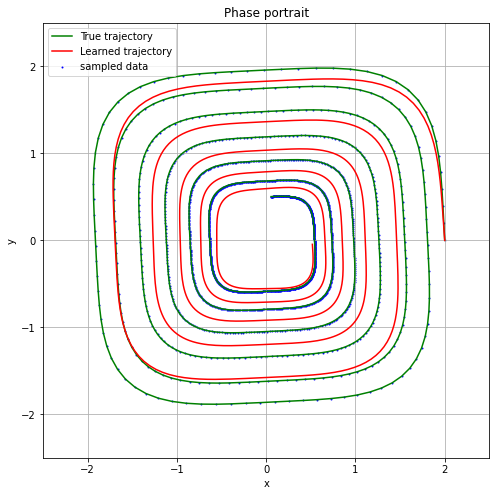

iter 0350|Total Loss: 1.295102


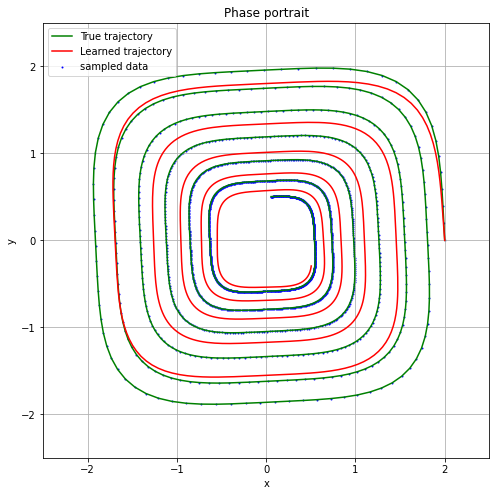

iter 0400|Total Loss: 1.277501


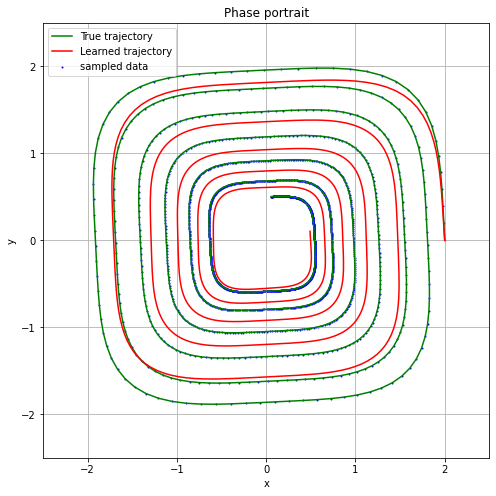

The process time: 22.207308530807495sec


In [ ]:
n_iters=400
func=ODEFunct()

optimizer=optim.RMSprop(func.parameters(),lr=1e-3)


start_time=time.time()

for iter in tqdm(range(n_iters+1)):
  optimizer.zero_grad()
  batch_y0,batch_t,batch_y=get_batch()  #Here batch_y is the label
  # print(batch_y0.shape,batch_t.shape,batch_y.shape)
  pred_y=odeint(func=func,y0=batch_y0,t=batch_t,rtol=1e-7,atol=1e-9,method='dopri8')#y0 will be the starting point and t will be the time step
  loss=torch.mean(torch.abs(pred_y-batch_y))
  loss.backward()
  optimizer.step()

  if iter%50==0:
    with torch.no_grad():
      pred_y=odeint(func,true_y0,t,rtol=1e-7,atol=1e-9,method='dopri8')
      loss=torch.mean(torch.abs(pred_y-true_y0))
      print('iter {:04d}|Total Loss: {:.6f}'.format(iter,loss.item()))
      Viz(True_y,pred_y)

end_time=time.time()
print('The process time: {}sec'.format(end_time-start_time))



# Now let's check how the results of the above torch solver differs from the result of adaptive back propagation method.

#we also get this solver from torchdiffeq

In [ ]:
from torchdiffeq import odeint_adjoint as odeinta 

  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000|Total Loss: 1.269866


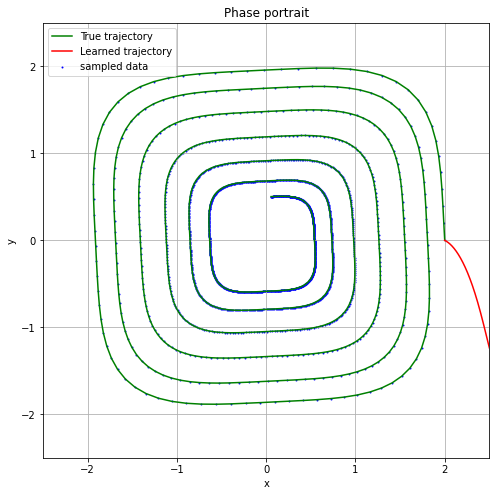

iter 0050|Total Loss: 1.217897


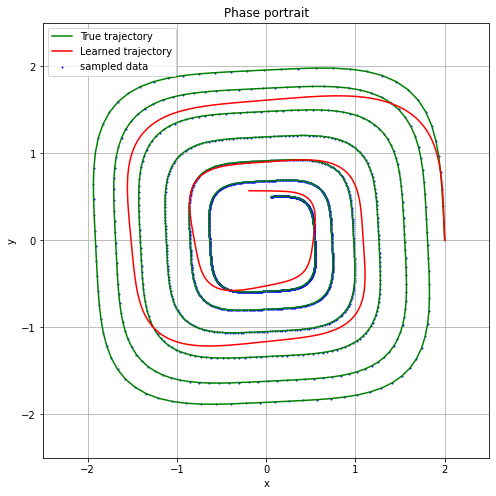

iter 0100|Total Loss: 1.272904


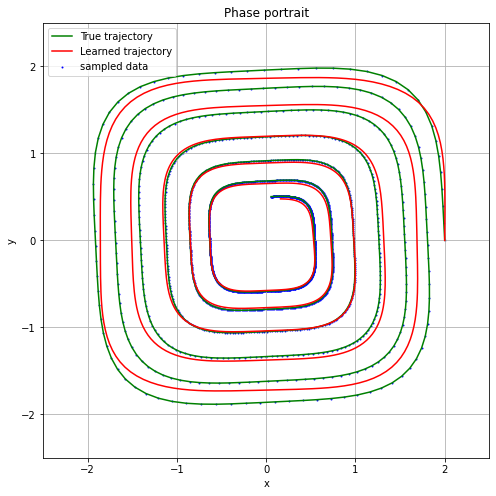

iter 0150|Total Loss: 1.265810


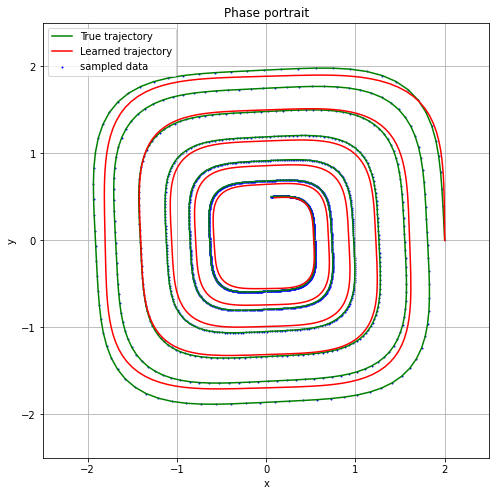

iter 0200|Total Loss: 1.296787


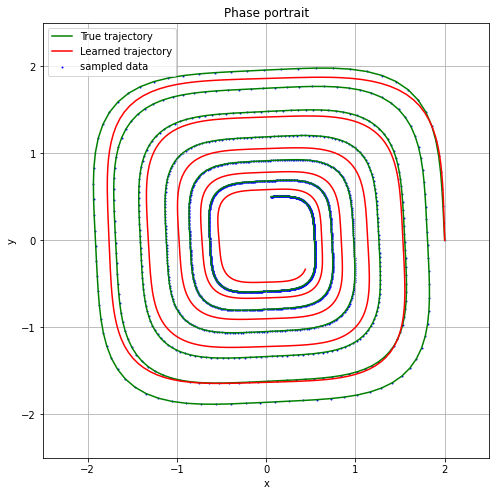

iter 0250|Total Loss: 1.267857


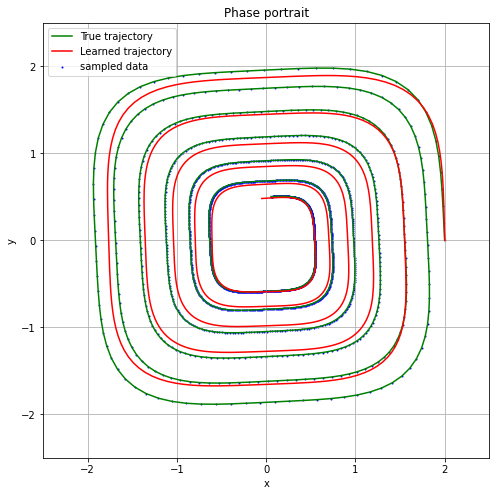

iter 0300|Total Loss: 1.235166


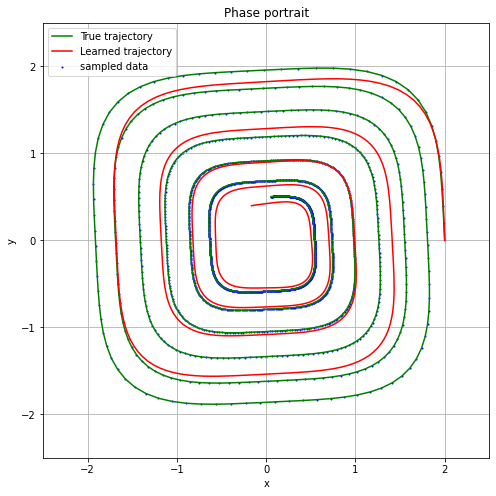

iter 0350|Total Loss: 1.291046


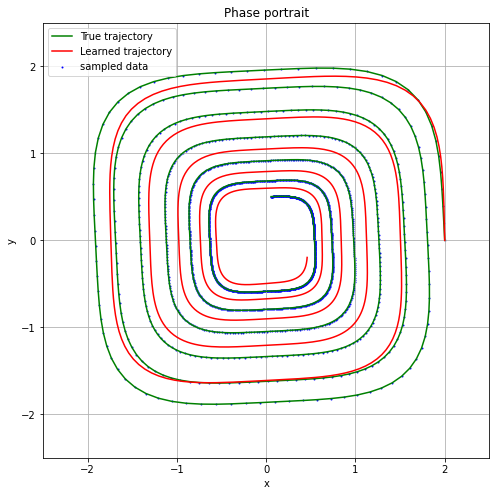

iter 0400|Total Loss: 1.282854


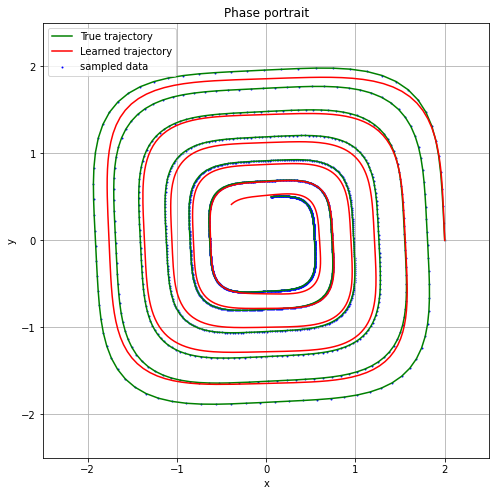

The process time: 63.88951826095581sec


In [ ]:
n_iters=400
func=ODEFunct()

optimizer=optim.RMSprop(func.parameters(),lr=1e-3)


start_time=time.time()

for iter in tqdm(range(n_iters+1)):
  optimizer.zero_grad()
  batch_y0,batch_t,batch_y=get_batch()  #Here batch_y is the label
  # print(batch_y0.shape,batch_t.shape,batch_y.shape)
  pred_y=odeinta(func=func,y0=batch_y0,t=batch_t,rtol=1e-7,atol=1e-9,method='dopri5')#y0 will be the starting point and t will be the time step
  loss=torch.mean(torch.abs(pred_y-batch_y))
  loss.backward()
  optimizer.step()

  if iter%50==0:
    with torch.no_grad():
      pred_y=odeinta(func,true_y0,t,rtol=1e-7,atol=1e-9,method='dopri5')
      loss=torch.mean(torch.abs(pred_y-true_y0))
      print('iter {:04d}|Total Loss: {:.6f}'.format(iter,loss.item()))
      Viz(True_y,pred_y)

end_time=time.time()
print('The process time: {}sec'.format(end_time-start_time))

